# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
        
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

IMAGE_SIZE = 32

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [4]:
# Show chosen traffic sign images
def show_images(images, labels, indexes, row, col):
    fig = plt.figure(figsize=(IMAGE_SIZE, IMAGE_SIZE))

    for i, index in enumerate(indexes):
        image = images[index]
        label = labels[index]

        ax = plt.subplot(row, col , i + 1)
        if label == -1:
            ax.set_title('None')
        else:
            ax.set_title(signnames[label])
        plt.axis('off')
        plt.imshow(image.squeeze(), cmap='gray')

    plt.show()

In [5]:
# Get traffic sign names
import csv
signnames = []
with open('signnames.csv', 'rt') as csvfile:
    for i in list(csv.reader(csvfile, delimiter=','))[1:]:
        signnames.append(i[1])

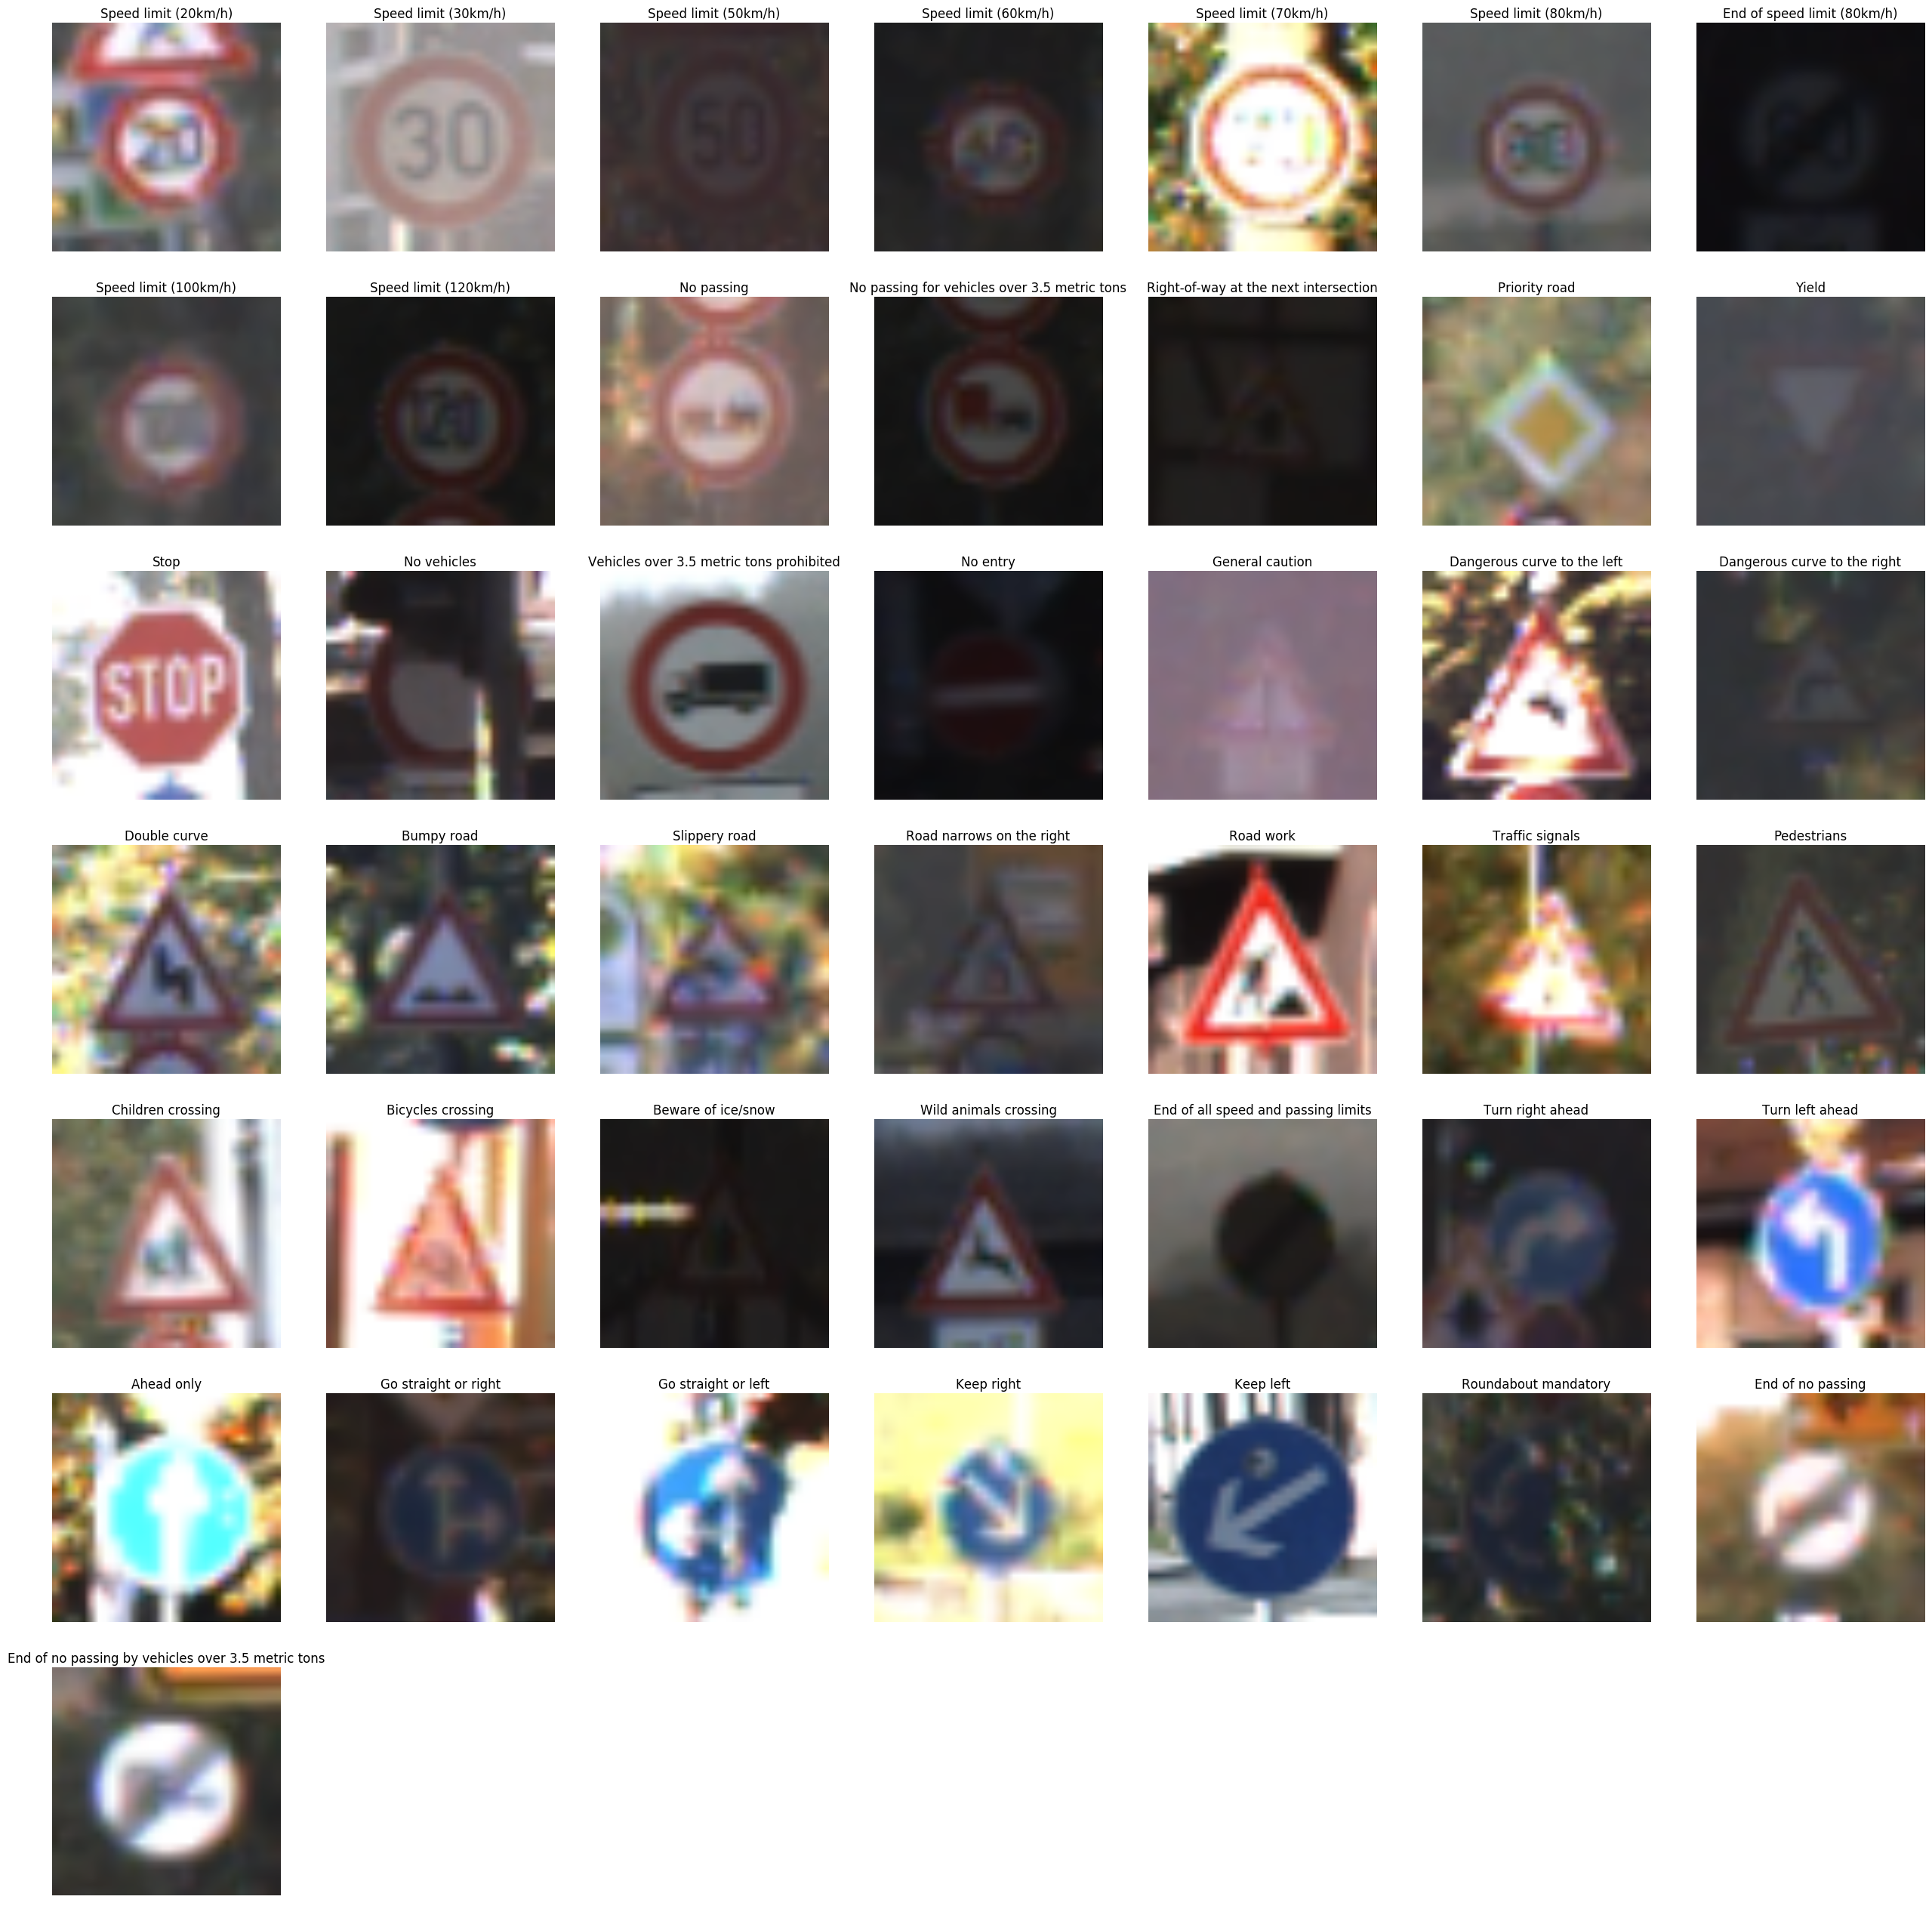

In [6]:
# Get sample images of each label
def get_sample_images():
    images = []
    
    label = 0
    
    for index in range(n_train):
        if label == y_train[index]:
            images.append(X_train[index])
            label += 1
            
    return images

sample_images = get_sample_images()
sample_labels = range(0, 43)
sample_indexes = sample_labels
show_images(sample_images, sample_labels, sample_indexes, 7, 7)

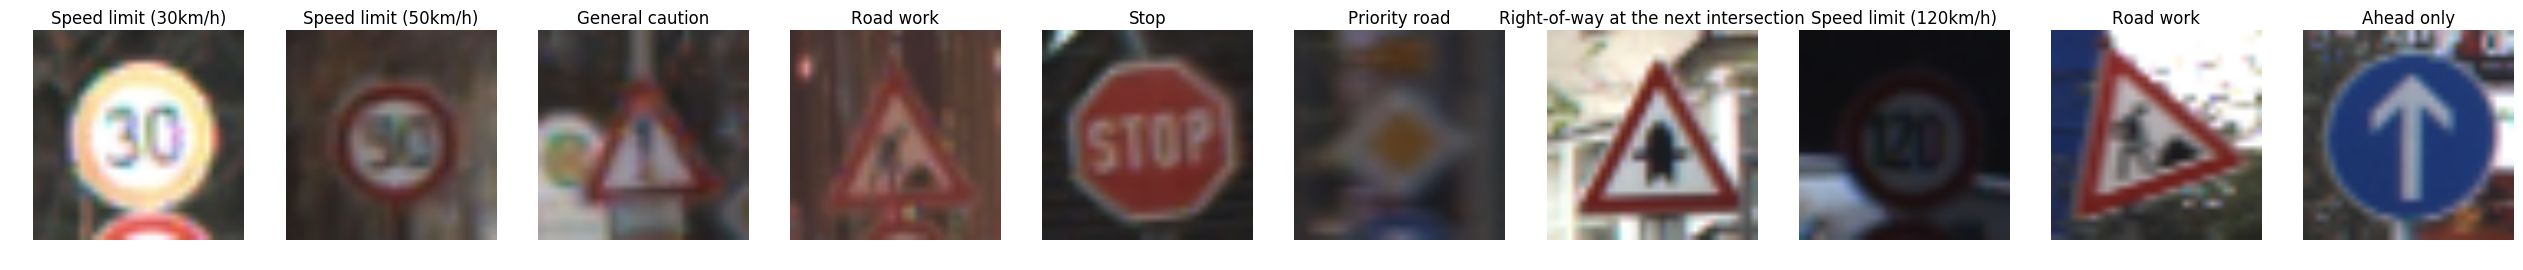

In [7]:
#Get 10 random traffic sign images
import random

N_IMAGES = 10

indexes = []

for i in range(N_IMAGES):
    indexes.append(random.randint(0, n_train))
    
show_images(X_train, y_train, indexes, 1, N_IMAGES)

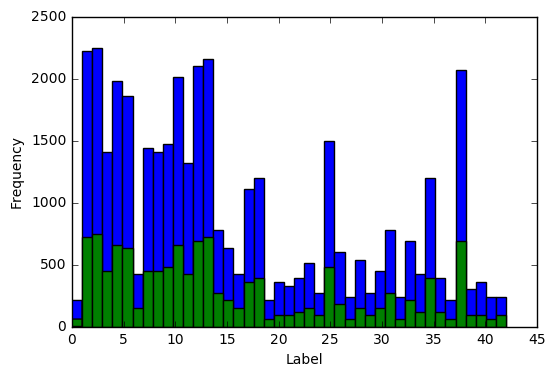

In [8]:
# Distribution of train and test data
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.hist(y_train,bins=n_classes)
plt.hist(y_test,bins=n_classes)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [9]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

import numpy as np
import cv2

# Change to grayscale
def to_gray(images):
    images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
    return images

# Normalize images
def normalize_grayscale(image_data):
    result = []
    
    a = 0.1
    b = 0.9
    x_min = 0
    x_max = 255

    for x in image_data:
        normalized = a + (((x - x_min) * (b - a)) / (x_max - x_min))
        result.append(normalized)

    return result

def preprocess_images(images):
    images = to_gray(images)
    images = normalize_grayscale(images)
    images = np.array(images).reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1))

    return images

X_train = preprocess_images(X_train)
X_test = preprocess_images(X_test)

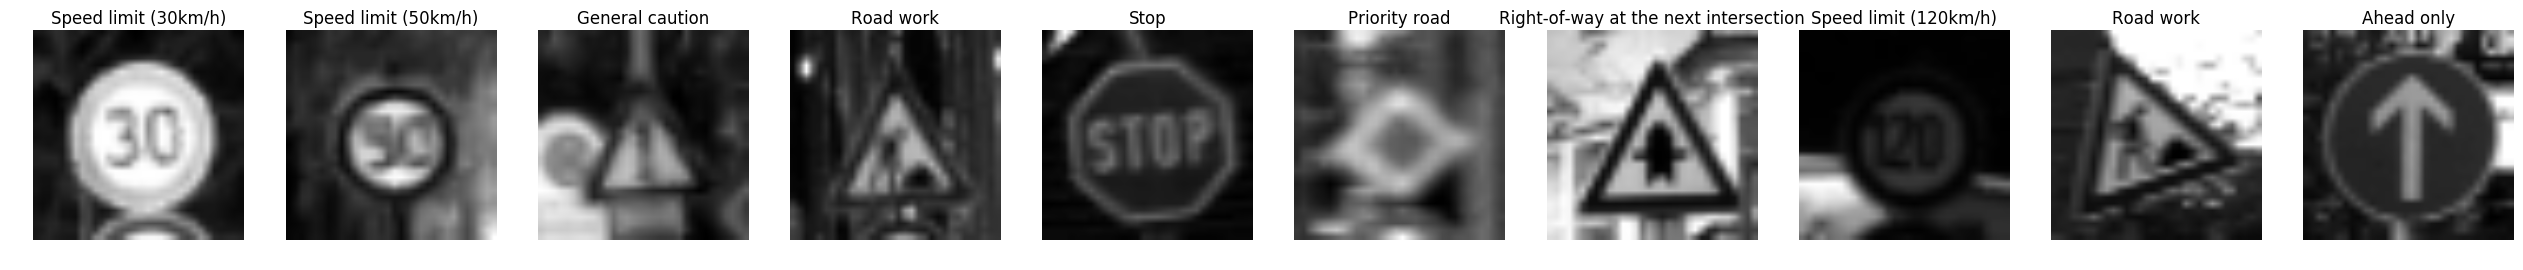

In [10]:
# Show chosen normaized images
show_images(X_train, y_train, indexes, 1, N_IMAGES)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
1. Convert to grayscale - To make same environment with LeNet, I converted the image set to grayscale. We can classify the images without color. It will reduce train time.
2. Normalize grayscale image - Normalize makes easier for optimization to proceed numerically.

After preprocessing, I reshaped images to use as input of LeNet.

In [11]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

In [12]:
def show_image_compare(original, jittered):
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.imshow(jittered, cmap='gray')

image = X_train[0].squeeze()

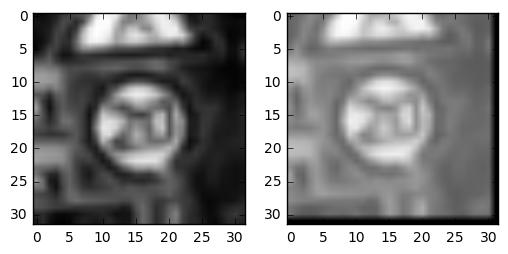

In [13]:
def translate_image(image):
    px = 2
    x, y = np.random.randint(-px, px, 2)
    M = np.float32([[1, 0, x], [0, 1, y]])
    return cv2.warpAffine(image,M,(IMAGE_SIZE, IMAGE_SIZE))

show_image_compare(image, translate_image(image))

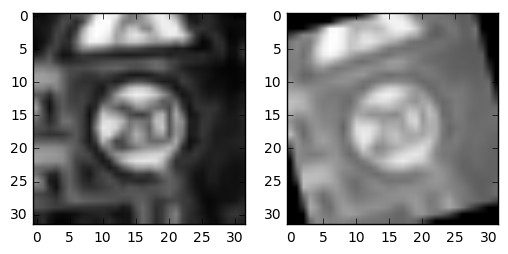

In [14]:
def rotate_image(image):
    degree = np.random.randint(-15, 15)
    M = cv2.getRotationMatrix2D((IMAGE_SIZE / 2, IMAGE_SIZE / 2), degree, 1)  
    dst = cv2.warpAffine(image, M, (IMAGE_SIZE, IMAGE_SIZE))
    return dst

show_image_compare(image, rotate_image(image))

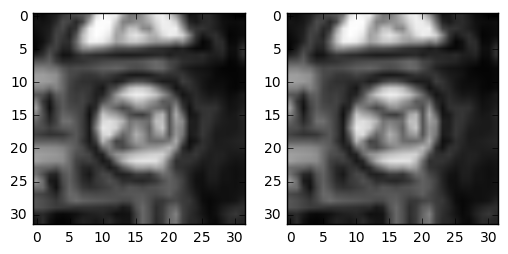

In [15]:
def scale_image(image):
    px = np.random.randint(-2, 2)
    row = IMAGE_SIZE
    col = IMAGE_SIZE
    
    pts1 = np.float32([[px, px],[row - px, px],[px, col - px],[row - px, col - px]])
    pts2 = np.float32([[0, 0], [row, 0],[0, col], [row, col]])

    M = cv2.getPerspectiveTransform(pts1, pts2)

    dst = cv2.warpPerspective(image, M, (row, col))
    
    return dst

show_image_compare(image, scale_image(image))

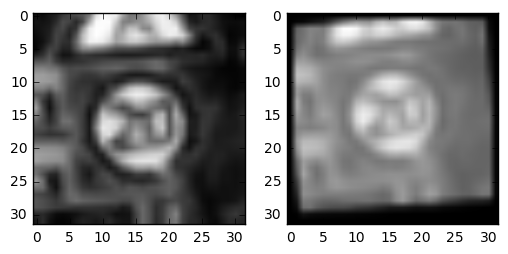

In [16]:
def apply_all_transform(image):
    return scale_image(rotate_image(translate_image(image)))

show_image_compare(image, apply_all_transform(image))

In [17]:
def build_jittered_image_set(images, func):
    images = np.array([func(image) for image in images])
    images = images.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1))
    return images

In [18]:
print('Generating additional data...')

jitter_functions = [translate_image, rotate_image, scale_image, apply_all_transform]

jittered_image_sets = []

for func in jitter_functions:
    jittered_images = build_jittered_image_set(X_train, func)
    jittered_image_sets.append(jittered_images)

for jittered_images in jittered_image_sets:
    X_train = np.concatenate((X_train, jittered_images))

y_train = np.array([y_train,] * (len(jittered_image_sets) + 1)).flatten()

n_train = len(X_train)
    
print("Number of training examples =", n_train)

Generating additional data...
Number of training examples = 196045


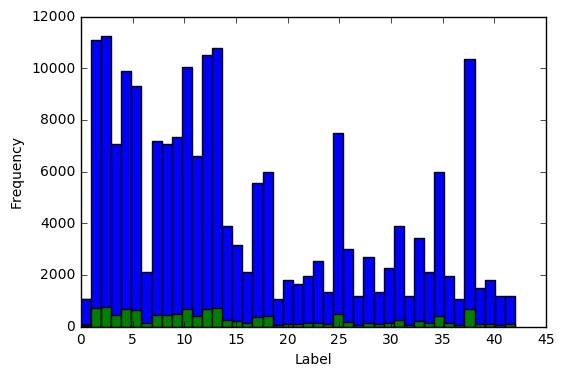

In [19]:
# Distribution of train and test data
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.hist(y_train,bins=n_classes)
plt.hist(y_test,bins=n_classes)
plt.show()

In [20]:
# Split the train data into training/validation sets.
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [21]:
n_train = len(X_train)
n_validation = len(X_validation)
print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)

Number of training examples = 156836
Number of validation examples = 39209


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
I generated additional data to increase accuracy of my model. The accuracy increased about 0.1% but it was small than I expected. I build a jittered dataset by adding transformed versions of the original training set. Samples are randomly perturbed in position ([-2,2] pixels), in scale ([.9,1.1] ratio) and rotation ([-15,+15] degrees).

I used 20% of training data as validation data after generating additional data.

For test data, I just used vanilla version of test data.

In [22]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def MSCNN(x, weights, biases, keep_prob):
    # Layer 1 32 * 32 * 1 to 28 * 28 * 6
    conv1 = tf.nn.conv2d(x, weights['conv1'], strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.bias_add(conv1, biases['conv1'])
    conv1 = tf.nn.relu(conv1)
    
    # 28 * 28 * 6 to 14 * 14 * 6
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2 14 * 14 * 6 to 10 * 10 * 16
    conv2 = tf.nn.conv2d(conv1, weights['conv2'], strides=[1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.bias_add(conv2, biases['conv2'])
    conv2 = tf.nn.relu(conv2)
    
    # 10 * 10 * 16 to 5 * 5 * 16
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Convolutions Layer 2
    conv3 = tf.nn.conv2d(conv2, weights['conv3'], strides=[1, 1, 1, 1], padding='VALID')
    conv3 = tf.nn.bias_add(conv3, biases['conv3'])
    conv3 = tf.nn.relu(conv3)  

    # Flatten conv3 400
    flatten_conv3 = flatten(conv3)
    
    # Flatten Layer1 1176
    flatten_layer1 = flatten(conv1)
    
    # Concatenate conv3 and Layer1
    fc1 = tf.concat_v2([flatten_conv3, flatten_layer1], 1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 3 Fully Connected 1576 to 43
    logits = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    
    return logits 

In [27]:
img_size = 32
num_channels = 1

def get_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def get_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def conv_layer(input,
               num_inp_channels,
               filter_size,
               num_filters,
              use_pooling):
    shape = [filter_size, filter_size, num_inp_channels,num_filters]
    weights = get_weights(shape)
    biases = get_biases(num_filters)
    layer = tf.nn.conv2d(input = input,
                        filter = weights,
                        strides = [1,1,1,1],
                        padding = 'SAME')

    layer += biases
    
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                         ksize=[1, 2, 2, 1],
                         strides=[1, 2, 2, 1],
                         padding='SAME')
    layer = tf.nn.relu(layer)
    
    return layer, weights

def fc_layer(input,          # The previous layer.
             num_inputs,     # Num. inputs from prev. layer.
             num_outputs,    # Num. outputs.
             use_relu=True): # Use Rectified Linear Unit (ReLU)?
    weights = get_weights(shape=[num_inputs, num_outputs])
    biases = get_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer,weights

def dropout_layer(layer, keep_prob):
    layer_drop = tf.nn.dropout(layer, keep_prob)
    return layer_drop

def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

def vivek(features):
    ## Convlayer 0
    filter_size0 = 1
    num_filters0 = 3

    ## Convlayer 1
    filter_size1 = 5
    num_filters1 = 32
    ## Convlayer 2
    filter_size2 = 5
    num_filters2 = 32

    ## Convlayer 3
    filter_size3 = 5
    num_filters3 = 64
    ## Convlayer 4
    filter_size4 = 5
    num_filters4 = 64

    ## Convlayer 5
    filter_size5 = 5
    num_filters5 = 128
    ## Convlayer 6
    filter_size6 = 5
    num_filters6 = 128

    ## FC_size 
    fc_size1 = 1024
    ## FC_size 
    fc_size2 = 1024

    layer_conv0, weights_conv0 = \
            conv_layer(input=features,
                       num_inp_channels=num_channels,
                       filter_size=filter_size0,
                       num_filters=num_filters0,
                       use_pooling=False)

    layer_conv1, weights_conv1 = \
            conv_layer(input=layer_conv0,
                       num_inp_channels=num_filters0,
                       filter_size=filter_size1,
                       num_filters=num_filters1,
                       use_pooling=False)
    layer_conv2, weights_conv2 = \
            conv_layer(input=layer_conv1,
                       num_inp_channels=num_filters1,
                       filter_size=filter_size2,
                       num_filters=num_filters2,
                       use_pooling=True)
    layer_conv2_drop = dropout_layer(layer_conv2, keep_prob)

    layer_conv3, weights_conv3 = \
            conv_layer(input=layer_conv2_drop,
                       num_inp_channels=num_filters2,
                       filter_size=filter_size3,
                       num_filters=num_filters3,
                       use_pooling=False)
    layer_conv4, weights_conv4= \
            conv_layer(input=layer_conv3,
                       num_inp_channels=num_filters3,
                       filter_size=filter_size4,
                       num_filters=num_filters4,
                       use_pooling=True)
    layer_conv4_drop = dropout_layer(layer_conv4, keep_prob)

    layer_conv5, weights_conv5 = \
            conv_layer(input=layer_conv4_drop,
                       num_inp_channels=num_filters4,
                       filter_size=filter_size5,
                       num_filters=num_filters5,
                       use_pooling=False)
    layer_conv6, weights_conv6 = \
            conv_layer(input=layer_conv5,
                       num_inp_channels=num_filters5,
                       filter_size=filter_size6,
                       num_filters=num_filters6,
                       use_pooling=True)    
    layer_conv6_drop = dropout_layer(layer_conv6, keep_prob)


    layer_flat2, num_fc_layers2 = flatten_layer(layer_conv2_drop)
    layer_flat4, num_fc_layers4 = flatten_layer(layer_conv4_drop)
    layer_flat6, num_fc_layers6 = flatten_layer(layer_conv6_drop)

    layer_flat = tf.concat(1, [layer_flat2, layer_flat4, layer_flat6])
    num_fc_layers = num_fc_layers2+num_fc_layers4+num_fc_layers6

    fc_layer1,weights_fc1 = fc_layer(layer_flat,          # The previous layer.
                 num_fc_layers,     # Num. inputs from prev. layer.
                 fc_size1,    # Num. outputs.
                 use_relu=True)
    fc_layer1_drop = dropout_layer(fc_layer1, keep_prob)

    fc_layer2,weights_fc2 = fc_layer(fc_layer1_drop,          # The previous layer.
                 fc_size1,     # Num. inputs from prev. layer.
                 fc_size2,    # Num. outputs.
                 use_relu=True)
    fc_layer2_drop = dropout_layer(fc_layer2, keep_prob)

    fc_layer3,weights_fc3 = fc_layer(fc_layer2_drop,          # The previous layer.
                 fc_size2,     # Num. inputs from prev. layer.
                 n_classes,    # Num. outputs.
                 use_relu=False)
    return fc_layer3

In [28]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):
    mu = 0
    sigma = 0.1

    weights = {
        'conv1': tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean=mu, stddev=sigma)),
        'conv2': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma)),
        'fc1': tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma)),
        'fc2': tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean=mu, stddev=sigma))
    }

    biases = {
        'conv1': tf.Variable(tf.zeros([6])),
        'conv2': tf.Variable(tf.zeros([16])),
        'fc1': tf.Variable(tf.zeros([120])),
        'fc2': tf.Variable(tf.zeros([84])),
        'out': tf.Variable(tf.zeros([n_classes])),
    }

    # Layer 1 32 * 32 * 1 to 28 * 28 * 6
    conv1 = tf.nn.conv2d(x, weights['conv1'], strides=[1, 1, 1, 1], padding='VALID') + biases['conv1']
    conv1 = tf.nn.relu(conv1)
    
    # 28 * 28 * 6 to 14 * 14 * 6
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2 14 * 14 * 6 to 10 * 10 * 16
    conv2 = tf.nn.conv2d(conv1, weights['conv2'], strides=[1, 1, 1, 1], padding='VALID') + biases['conv2']
    conv2 = tf.nn.relu(conv2)
    
    # 10 * 10 * 16 to 5 * 5 * 16
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten
    fc0 = flatten(conv2)
    
    # Layer 3 Fully connected 400 to 120
    fc1 = tf.add(tf.matmul(fc0, weights['fc1']), biases['fc1'])
    fc1 = tf.nn.relu(fc1)    
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4 Fully connected 120 to 84
    fc2 = tf.add(tf.matmul(fc1, weights['fc2']), biases['fc2'])
    fc2 = tf.nn.relu(fc2)    
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 5 Fully connected 84 to output
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    
    return logits

In [29]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

At first, I used LeNet architecture in LeNet Lab as it is except the output of the model.
But I tried [Traffic Sign Recognition with Multi-Scale Convolutional Networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), it works well than LeNet.


**Layer 1: Convolutional**. output is 28x28x6.

**Relu Activation.**

**Pooling.** output is 14x14x6. This will be used in Layer 3.

**Layer 2: Convolutional.** output 10x10x16.

**Relu Activation.**

**Pooling.** output is 5x5x16.

**Convolution Layer2.** output is 400.

**Relu Activation.**

**Flatten the output of Layer1.** output is 1176.

**Concatenate flatten Layer 1 and the output of Layer2.** output is 1576

**Drop out with probability 0.5.**

**Layer 3:** Fully Connected (Logits). output is 43.


In [30]:
### Train your model here.
### Feel free to use as many code cells as needed.
EPOCHS = 20
BATCH_SIZE = 128
learning_rate = 0.001
keep_prob = tf.placeholder(tf.float32, None)

mu = 0
sigma = 0.1

weights = {
    'conv1': tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean=mu, stddev=sigma)),
    'conv2': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma)),
    'conv3': tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean=mu, stddev=sigma)),
    'out': tf.Variable(tf.truncated_normal(shape=(1576, n_classes), mean=mu, stddev=sigma))
}

biases = {
    'conv1': tf.Variable(tf.zeros([6])),
    'conv2': tf.Variable(tf.zeros([16])),
    'conv3': tf.Variable(tf.zeros([400])),
    'out': tf.Variable(tf.zeros([n_classes])),
}

#logits = MSCNN(x, weights, biases, keep_prob)
#logits = LeNet(x, keep_prob)
logits = vivek(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss_operation)

In [31]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples    

In [ ]:
from sklearn.utils import shuffle

def train_model(X_train, y_train, epochs=0, save_path='', postfix=''):
    with tf.Session() as sess:
        if save_path:
            saver.restore(sess, save_path)
        else:
            sess.run(tf.global_variables_initializer())
            
        if epochs == 0:
            epochs = EPOCHS
            
        num_examples = len(X_train)

        print('Training...')
        print()

        for epoch in range(epochs):
            X_train, y_train = shuffle(X_train, y_train)

            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

            validation_accuracy = evaluate(X_validation, y_validation)
            print("EPOCH {} ...".format(epoch+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()

        saver.save(sess, 'lenet' + postfix)
        print("Model saved")

In [ ]:
train_model(X_train, y_train)

Training...

EPOCH 1 ...
Validation Accuracy = 0.909



In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

### Question 4
_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I almost used LeNet architecture as it is, except epochs.

**Optimizer:** Adam

**Batch Size:** 128

**Epochs:** 50

**Learning Rate:** 0.001

**mu:** 0

**sigma:** 0.1

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

At first I implement LeNet Lab as it is. Then I fine tuned some parameters like epochs, learning rate, and so on. Also I tried some data preprocessing and add dropout. It gave the test accuracy around 95%. I tried paper the above, and it gave the accuracy around 96%.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import csv

path = 'testdata/'
X_extra = []
y_extra = []

with open(path + 'image_info.csv', 'rt') as f:
    image_info = csv.reader(f, delimiter=',')
    for image_file, label in image_info:
        image = cv2.cvtColor(cv2.imread(path + image_file), cv2.COLOR_BGR2RGB)
        X_extra.append(image)
        y_extra.append(int(label))

extra_indexes = range(len(X_extra))
show_images(X_extra, y_extra, extra_indexes, 1, 11)

In [ ]:
# Preprocess image
X_extra = preprocess_images(X_extra)

In [ ]:
show_images(X_extra, y_extra, extra_indexes, 1, 11)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

There are two traffic signs that doesn't exist in data set. Model classified them similar shaped signs. Also I gave a damaged traffic sign as a input, but the model didn't classify it properly.

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    extra_test_accuracy = evaluate(X_extra, y_extra)
    print("Extra Test Accuracy = {:.3f}".format(extra_test_accuracy))
    print(sess.run(tf.argmax(logits, 1), feed_dict={x: X_extra, y: y_extra, keep_prob: 1.0}))
    print(y_extra)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

My model didn't classify properly Traffic sign 0 and 9.

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

K = 5

import matplotlib.gridspec as gridspec

softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=K)

with tf.Session() as sess:
    saver.restore(sess, "./lenet")
    top = tf.nn.top_k(softmax_logits, K)

    top_pred = sess.run([softmax_logits, top_k], feed_dict={x: X_extra, keep_prob: 1.0})
    
    for i in range(len(X_extra)):
        plt.figure(figsize = (K, 1.5))
        gs = gridspec.GridSpec(1, 2, width_ratios=[2,3])
        ax = plt.subplot(gs[0])
        ax.imshow(X_extra[i].squeeze(), cmap='gray')
        ax.axis('off')
        ax.set_title(signnames[y_extra[i]], loc='left')
        
        plt.subplot(gs[1])
        # Draw Bar
        plt.barh(6 - np.arange(K), top_pred[1][0][i], align='center')
        
        # Draw Bar text
        for i_label in range(K):
            plt.text(top_pred[1][0][i][i_label] + .02, 6 - i_label - .25,
                     '{} ({:.2f}%)'.format(
                         signnames[top_pred[1][1][i][i_label]],
                         top_pred[1][0][i][i_label] * 100
                     ))
        plt.axis('off');
        plt.show();


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

For the sign 0, the correct result was at rank2. But it is really uncertain about it. it's probability is 1.26 %

For the sign 9, the correct result was at rank2. It is also really uncertain about it. it's probability is almost 0%.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.